In [2]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\j\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [4]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Nacitanie dat z db (live data z monant snapshotu)

In [5]:
create_view_query = '''
DROP MATERIALIZED VIEW IF EXISTS article_fb_latest;
CREATE MATERIALIZED VIEW article_fb_latest AS
(
SELECT sbq.url, sbq.sync_date, sbq.reaction_count, sbq.comment_count, sbq.share_count
FROM (
         SELECT afe.*, row_number() OVER (PARTITION BY url ORDER BY sync_date DESC) as rn
         FROM article_fb_engagement afe
     ) sbq
WHERE sbq.rn = 1)
'''

with engine.connect() as connection:
    connection.execute(create_view_query)

In [6]:
fetch_data_query = '''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       coalesce(imgc.cnt, 0)                          as image_count,
       coalesce(vidc.cnt, 0)                          as video_count,
       av.veracity,
       av.claims_false,
       av.claims_mixture,
       av.claims_mostly_false,
       av.claims_mostly_true,
       av.claims_true,
       av.claims_unknown,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable,
       sync_date                                      as fb_sync_date,
       reaction_count                                 as fb_reaction_count,
       comment_count                                  as fb_comment_count,
       share_count                                    as fb_share_count,
       (reaction_count + comment_count + share_count) as fb_popularity
FROM article a
         JOIN source s on a.source_id = s.id
         JOIN (SELECT * FROM article_fb_latest) p ON a.url = p.url
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'image' GROUP BY article_id) imgc
                   ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'video' GROUP BY article_id) vidc
                   ON a.id = vidc.article_id
         JOIN article_veracity av on a.id = av.article_id
WHERE s.url !~ '(\.sk$)|(\.cz$)' -- remove cz/sk sources
  AND s.name NOT IN ('badatel.net', -- cz/sk portals not using cz/sk domain
                     'energiezivota.com')
  AND a.published_at IS NOT NULL
  AND s.is_reliable IS NOT NULL;
'''

df = pd.sql(fetch_data_query)
df_copy = df.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60955 entries, 0 to 60954
Data columns (total 30 columns):
id                     60955 non-null int64
url                    60955 non-null object
title                  60955 non-null object
perex                  53234 non-null object
body                   60934 non-null object
published_at           60955 non-null datetime64[ns]
extracted_at           60955 non-null datetime64[ns]
source_id              60955 non-null int64
category               52141 non-null object
other_info             60953 non-null object
image_count            60955 non-null int64
video_count            60955 non-null int64
veracity               60955 non-null object
claims_false           60955 non-null int64
claims_mixture         60955 non-null int64
claims_mostly_false    60955 non-null int64
claims_mostly_true     60955 non-null int64
claims_true            60955 non-null int64
claims_unknown         60955 non-null int64
author_name            60955 n

In [8]:
df.head()

,id,url,title,perex,body,published_at,extracted_at,source_id,category,other_info,...,source_id,source_name,source_url,source_type,source_is_reliable,fb_sync_date,fb_reaction_count,fb_comment_count,fb_share_count,fb_popularity
0,235039,https://www.naturalnewsblogs.com/angelina-joli...,Angelina Jolie copied by men! Surgeons now cut...,<p>(NaturalNews) Beyond merely inspiring women...,(NaturalNews) Beyond merely inspiring women to...,2013-05-20 18:54:30,2019-09-05 06:45:28.083048,142,"[Health, Science, Weird, Celebrity, Hospitals ...","{'tags': ['Angelina Jolie', 'BRCA genes', 'pro...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0
1,235080,https://www.collective-evolution.com/2019/08/2...,Scientist Discovers Cells That ‘Ingest’ Vaccin...,What&#8217;s happening in our world with regar...,What’s happening in our world with regards to ...,2019-08-20 14:28:14,2019-09-05 06:45:32.405077,144,[Awareness],"{'tags': ['Awareness', 'Health', 'Wellness'], ...",...,144,collective-evolution.com,http://collective-evolution.com,news_website,0,2019-10-14 15:29:44.600421,2512,527,1777,4816
2,235087,https://www.collective-evolution.com/2019/08/0...,Infant Vaccine Death Testimonies Mount As We C...,The process of awakening&#8211;discarding the ...,The process of awakening–discarding the veils ...,2019-08-08 13:55:27,2019-09-05 06:45:33.838503,144,[Health],"{'tags': ['Health'], 'updated_at': '2019-08-08...",...,144,collective-evolution.com,http://collective-evolution.com,news_website,0,2019-10-14 15:29:46.467058,1127,201,473,1801
3,235113,https://www.collective-evolution.com/2019/06/2...,Dogs Can Detect Lung Cancer With 97 Percent Ac...,"Animals are a precious gift to humanity, and w...","Animals are a precious gift to humanity, and w...",2019-06-26 16:46:01,2019-09-05 06:45:37.497266,144,[Alternative News],"{'tags': ['Alternative News', 'Awareness', 'He...",...,144,collective-evolution.com,http://collective-evolution.com,news_website,0,2019-10-14 15:29:46.467058,229,25,133,387
4,235114,https://www.naturalnewsblogs.com/consumer-watc...,Consumer watchdog group lowers safety rating o...,"<p>If you haven&#8217;t done so already, it&#8...","If you haven’t done so already, it’s time to h...",2013-08-14 13:13:01,2019-09-05 06:45:37.544950,142,"[Health, Food]","{'tags': ['additive', 'Additives', 'artificial...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:46.467058,0,0,0,0


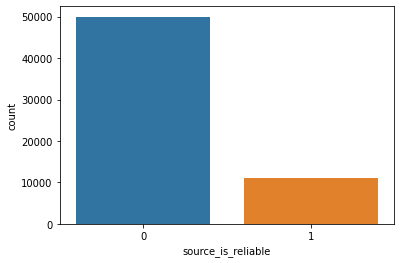

In [9]:
sns.countplot(x='source_is_reliable', data=df)

In [10]:
df['fb_popularity'].describe().apply(lambda x: '%.3f' % x)

count      60955.000
mean        1140.041
std        29800.535
min            0.000
25%            0.000
50%            2.000
75%          121.000
max      5197586.000
Name: fb_popularity, dtype: object

In [11]:
def draw_publishing_per_year(df):
    published_in_year = df.published_at.apply(lambda x: x.year)
    with figsize(plt, 20, 5):
        cplt = sns.countplot(published_in_year, color='black')
        cplt.set(xlabel='Rok publikovania', ylabel='Počet článkov')
        return cplt


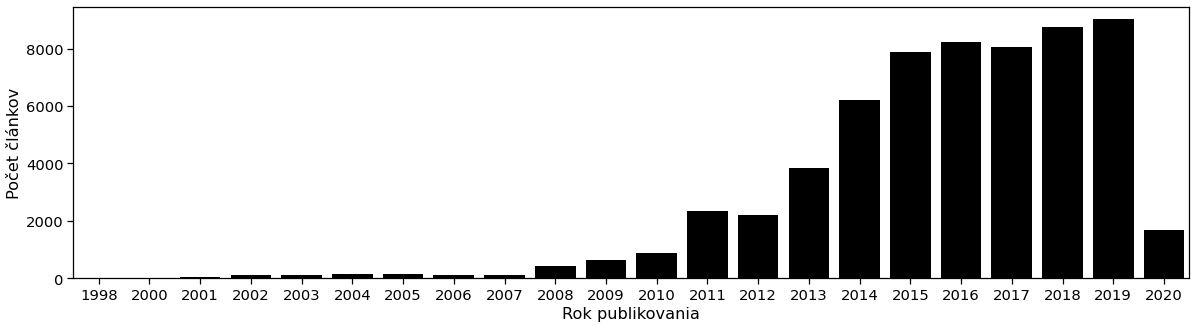

In [12]:
with sns.plotting_context("notebook", font_scale=1.35):
    draw_publishing_per_year(df).get_figure().savefig('export/clanky-per-rok.png')

Cut the articles so we use only those from 2011 - now

In [13]:
df = df[df.published_at > '2011-01-01']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58179 entries, 0 to 60954
Data columns (total 30 columns):
id                     58179 non-null int64
url                    58179 non-null object
title                  58179 non-null object
perex                  50458 non-null object
body                   58158 non-null object
published_at           58179 non-null datetime64[ns]
extracted_at           58179 non-null datetime64[ns]
source_id              58179 non-null int64
category               49365 non-null object
other_info             58177 non-null object
image_count            58179 non-null int64
video_count            58179 non-null int64
veracity               58179 non-null object
claims_false           58179 non-null int64
claims_mixture         58179 non-null int64
claims_mostly_false    58179 non-null int64
claims_mostly_true     58179 non-null int64
claims_true            58179 non-null int64
claims_unknown         58179 non-null int64
author_name            58179 n

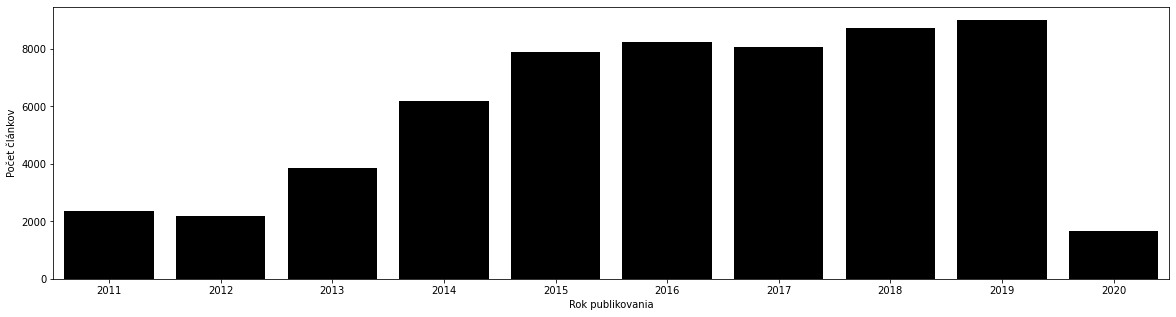

In [15]:
draw_publishing_per_year(df)

In [16]:
df[['source_name', 'source_is_reliable']].groupby('source_name').first()['source_is_reliable'].value_counts()

0    46
1    20
Name: source_is_reliable, dtype: int64

In [17]:
display_all(df[['source_is_reliable', 'fb_reaction_count', 'fb_comment_count', 'fb_share_count']] .groupby('source_is_reliable').describe())

fb_reaction_count                                           \
                               count        mean           std  min  25%  50%   
source_is_reliable                                                              
0                            47763.0  827.314092  24617.757464  0.0  0.0  0.0   
1                            10416.0  324.391801   2221.511356  0.0  0.0  1.0   

                                      fb_comment_count              \
                       75%        max            count        mean   
source_is_reliable                                                   
0                    61.00  3929532.0          47763.0  194.491992   
1                   114.25   125529.0          10416.0   94.969470   

                                                               fb_share_count  \
                            std  min  25%  50%   75%       max          count   
source_is_reliable                                                              
0                   5023.332499  0.0  0.0  0.0   8.0  714968.0        47763.0   
1                    587.690864  0.0  0.0  0.0  20.0   19901.0        10416.0   

                                                                             
                          mean          std  min  25%  50%    75%       max  
source_is_reliable                                                           
0                   307.831376  4922.862307  0.0  0.0  2.0  41.00  572708.0  
1                   117.631144   685.961039  0.0  0.0  2.0  56.25   31906.0

In [18]:
df_gb_pop = df.groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)
df_gb_pop['is_reliable'] = df.groupby('source_url')['source_is_reliable'].first()
display_all(df_gb_pop)

,count,mean,std,min,25%,50%,75%,max,is_reliable
source_url,,,,,,,,,
http://naturalnewsblogs.com,9182.0,96.808538,1022.869151,0.0,0.00,0.0,2.00,30716.0,0
http://naturalnews.com,7492.0,1712.339963,63124.642764,0.0,34.00,116.0,299.00,5197586.0,0
http://neurosciencenews.com,3850.0,377.651429,4017.285610,0.0,0.00,0.0,121.00,169047.0,1
http://healthimpactnews.com,3082.0,621.850746,15488.286171,0.0,0.00,1.0,32.00,841807.0,0
http://healthnutnews.com,2748.0,1647.471252,14092.792040,0.0,10.00,197.5,675.50,519664.0,0
http://naturalsociety.com,2664.0,7.399024,273.606520,0.0,0.00,0.0,0.00,14042.0,0
http://statnews.com,2046.0,455.040078,2512.370622,0.0,0.00,0.0,164.00,72319.0,1
http://healthy-holistic-living.com,1918.0,4063.662148,26630.577505,0.0,0.00,2.0,31.75,524803.0,0
http://naturalhealth365.com,1703.0,257.461538,1132.917972,0.0,5.00,59.0,211.00,26509.0,0


In [19]:
df[df.source_is_reliable == True].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://neurosciencenews.com,3850.0,377.651429,4017.285610,0.0,0.00,0.0,121.00,169047.0
http://statnews.com,2046.0,455.040078,2512.370622,0.0,0.00,0.0,164.00,72319.0
http://sciencebasedmedicine.org,1496.0,994.717246,2781.252606,0.0,9.00,241.0,882.25,45781.0
http://vaxopedia.org,689.0,96.181422,253.328443,0.0,3.00,26.0,80.00,3024.0
http://medicinenet.com,552.0,7.414855,97.106580,0.0,0.00,0.0,0.00,2124.0
http://medicalnewstoday.com,270.0,877.474074,1183.145601,40.0,240.75,503.5,1048.00,10044.0
http://webmd.com,235.0,1157.319149,2627.254128,2.0,54.00,221.0,732.00,18417.0
http://medicaldaily.com,229.0,18.078603,37.453046,0.0,2.00,4.0,16.00,317.0
http://youngwomenshealth.org,223.0,18.730942,89.316066,0.0,0.00,1.0,5.00,903.0


In [20]:
df[df.source_is_reliable == False].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://naturalnewsblogs.com,9182.0,96.808538,1022.869151,0.0,0.00,0.0,2.00,30716.0
http://naturalnews.com,7492.0,1712.339963,63124.642764,0.0,34.00,116.0,299.00,5197586.0
http://healthimpactnews.com,3082.0,621.850746,15488.286171,0.0,0.00,1.0,32.00,841807.0
http://healthnutnews.com,2748.0,1647.471252,14092.792040,0.0,10.00,197.5,675.50,519664.0
http://naturalsociety.com,2664.0,7.399024,273.606520,0.0,0.00,0.0,0.00,14042.0
http://healthy-holistic-living.com,1918.0,4063.662148,26630.577505,0.0,0.00,2.0,31.75,524803.0
http://naturalhealth365.com,1703.0,257.461538,1132.917972,0.0,5.00,59.0,211.00,26509.0
http://consciouslifenews.com,1675.0,73.630448,280.609769,0.0,0.00,1.0,23.00,4745.0
http://sanevax.org,1554.0,9.515444,102.392821,0.0,0.00,0.0,0.00,2035.0


### Save final data

In [21]:
save_df(df, 'final_data.pickle')